<img src='https://micro.ce.sharif.edu/lib/tpl/writr/images/logo.svg' alt="SUT logo" width=150 height=150 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
 Deep Generative Models <br>
<font color=2565AE size=5>
Mathematics & Computer Science department - Fall 2024  <br>
<font color=3C99D size=5>
          Homework 5: Practical - Diffusion models <br>
<font color=696880 size=4>
AmirHossein Haji Mohammad Rezaei, Nasrin Amjadi
    
    
____


# Mohammad Mohamamdi - 402208592


# Problem

This assignment uses PyTorch to build and implement a Denoising Diffusion Probabilistic model (DDPM) to learn the distribution of sprites images and evaluate its generated images by using FID score.

- It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
- If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.


# Setup


In [1]:
from typing import Dict, Tuple
from tqdm import tqdm, trange
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image


## hyperparameters


In [2]:
# diffusion hyperparameters
timesteps = 1000
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64  # 64 hidden dimension feature
n_cfeat = 5  # context vector is of size 5
height = 16  # 16x16 image
save_dir = '/kaggle/working/'

# training hyperparameters
batch_size = 100
n_epoch = 40
lrate = 1e-3


## Sprites Dataset


In [3]:
!wget 'https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprites_1788_16x16.npy'
!wget 'https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprite_labels_nc_1788_16x16.npy'

--2025-01-27 18:27:32--  https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprites_1788_16x16.npy
Resolving huggingface.co (huggingface.co)... 3.165.160.59, 3.165.160.61, 3.165.160.12, ...
Connecting to huggingface.co (huggingface.co)|3.165.160.59|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/df/b9/dfb98dd9f5f7c221e653770544f82ac8de0044d1f52ab71a1e42ed1a332ae365/61cf3b7e3184f57f2bc2bf5e75fbcf08ba379241f58966c62a9716ef581b2916?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27sprites_1788_16x16.npy%3B+filename%3D%22sprites_1788_16x16.npy%22%3B&Expires=1738006053&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczODAwNjA1M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2RmL2I5L2RmYjk4ZGQ5ZjVmN2MyMjFlNjUzNzcwNTQ0ZjgyYWM4ZGUwMDQ0ZDFmNTJhYjcxYTFlNDJlZDFhMzMyYWUzNjUvNjFjZjNiN2UzMTg0ZjU3ZjJiYzJiZj

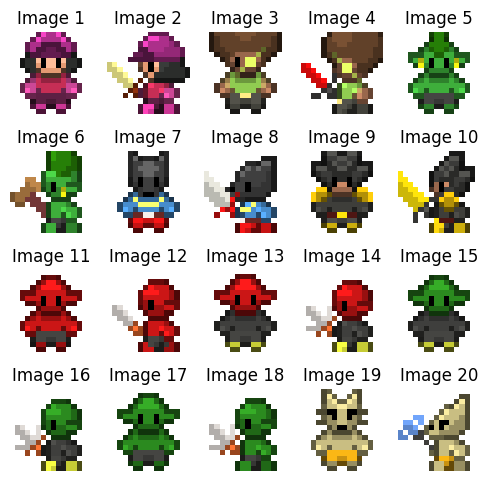

In [4]:
sprites_samples = np.load("/kaggle/working/sprites_1788_16x16.npy")[:20]
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5))
axes = axes.flatten()

# Loop through each image and plot it
for i in range(20):
    image = sprites_samples[i]

    # Plot the image in the appropriate subplot
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide axis
    axes[i].set_title(f'Image {i + 1}')  # Set title

# Hide any unused subplots
for j in range(20, num_rows * num_cols):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [5]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, _sprites, _slabels, transform, null_context=False):
        self.transform = transform
        self.null_context = null_context
        self.sprites = _sprites
        self.slabels = _slabels
        self.sprites_shape = self.sprites.shape
        self.slabel_shape = self.slabels.shape

    # Return the number of images in the dataset
    def __len__(self):
        return len(self.sprites)

    # Get the image and label at a given index
    def __getitem__(self, idx):
        # Return the image and label as a tuple
        if self.transform:
            image = self.transform(self.sprites[idx])
            if self.null_context:
                label = torch.tensor(0).to(torch.int64)
            else:
                label = torch.tensor(self.slabels[idx]).to(torch.int64)
        return (image, label)

    def getshapes(self):
        # return shapes of data and labels
        return self.sprites_shape, self.slabel_shape

transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    transforms.Normalize((0.5,), (0.5,))  # range [-1,1]
])


In [6]:
sprites = np.load("/kaggle/working/sprites_1788_16x16.npy")
slabels = np.load("/kaggle/working/sprite_labels_nc_1788_16x16.npy")

print(f"sprite shape: {sprites.shape}")
print(f"labels shape: {slabels.shape}")

train_sprites = sprites[:60000]
train_slabels = slabels[:60000]
val_sprites = sprites[60000:]
val_slabels = slabels[60000:]


sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [7]:
# load dataset
trian_dataset = CustomDataset(train_sprites, train_slabels, transform, null_context=False)
train_dataloader = DataLoader(trian_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# load dataset
val_dataset = CustomDataset(val_sprites, val_slabels, transform, null_context=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)


## UNet


So what model do we use to do this magical 'denoising' step? We've looked a little at basic convolutional neural networks that take in an image and output something like a classification. And we've seen autoencoders that go from an image down to a latent representation and back to an output image. Perhaps one of these would be suitable?


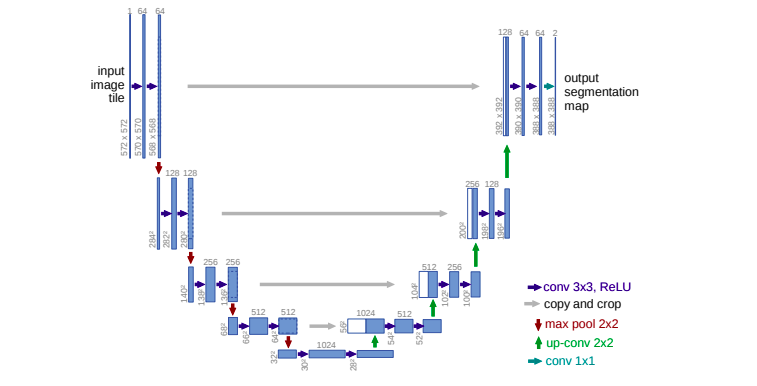

(Unet diagram from [the 2015 paper](https://arxiv.org/abs/1505.04597))


One issue with a typical 'bottlekneck' architecture like an autoencoder is that by design they loose the details around exact pixel coordinates. To get around this, an architecture called the Unet was introduced. Originally designed for segmentation tasks, the architecture (shown above) passes information from high-resolution, early layers to later layers. These 'shortcuts' let the network use detailed features from the original image while also capturing more high-level semantic information from the deeper layers.

These networks turned out to be great at all sorts of image-to-image tasks. Colorization , segmentation and so on. These days, typical unet models incorporate ideas such as attention and can be built around pretrained 'backbones' like resnet-50 for transfer learning tasks.

The implementation below is a fairly typical modern Unet with one extra trick: a TimeEmbedding which encodes the time step (t) and lets the model use this as conditioning information by passing it in in the middle of the network. Take a peek at the code and see if you can figure out roughly what's going on in the forward pass.


In [8]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()

        # Check if input and output channels are the same for the residual connection
        self.same_channels = in_channels == out_channels
        self.is_res = is_res

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            if self.same_channels:
                out = x + x2
            else:
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

    def get_out_channels(self):
        return self.conv2[0].out_channels

    def set_out_channels(self, out_channels):
        self.conv1[0].out_channels = out_channels
        self.conv2[0].in_channels = out_channels
        self.conv2[0].out_channels = out_channels



class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        layers = [
            ResidualConvBlock(in_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
            nn.MaxPool2d(2)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim  # <-- Make sure this is present!
        
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


In [9]:
class Unet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28):  # cfeat - context features
        super(Unet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d((self.h//4)), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4),
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, t, c=None):
        x_0 = self.init_conv(x)
        down1 = self.down1(x_0)
        down2 = self.down2(down1)

        hiddenvec = self.to_vec(down2)

        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x.device)

        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1 * up1 + temb1, down2)
        up3 = self.up2(cemb2 * up2 + temb2, down1)
        out = self.out(torch.cat((up3, x_0), 1))
        return out


## Training


In [10]:
# construct model
# TODO

# We'll construct a UNet with input channels=3 if the sprites are RGB,
# but since they're likely RGBA or single-channel, we need to check.
# The example data looks like it might have 4 channels or 3 channels or 1 channel.
# Let's assume 3 channels:
# If it's actually 4 or 1, adjust accordingly.
# We can check shape or use in_channels=3.

in_channels = 3 if sprites.shape[-1] == 3 else sprites.shape[-1]

nn_model = Unet(
    in_channels=in_channels,
    n_feat=n_feat,      # 64
    n_cfeat=n_cfeat,    # 5
    height=height       # 16
).to(device)

print(nn_model)


Unet(
  (init_conv): ResidualConvBlock(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
  )
  (down1): UnetDown(
    (model): Sequential(
      (0): ResidualConvBlock(
        (conv1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GELU(approximate='none')
        )
        (conv2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, mome

In [11]:
# construct optimizer
# TODO

optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)
print(optim)


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


We want to set up a "**variance schedule**" β, where $\beta_t$ specifies how much noise we want to add at that step. You get fancy schedules but we'll stick with a linear one for now. \\
At each time step t, the variance of the noise added to the previous step is predetermined by the variance schedule, and it's marked as $\beta_t$, where 0 < $\beta_1$ < $\beta_t$ < $\beta_2$ < 1.


In [12]:
# TODO: complete the code here
# Create Linear Scheduler - beta1 and beta2 are given in the hyperparameters block

# We'll linearly interpolate between beta1 and beta2 across timesteps

betas = torch.linspace(beta1, beta2, timesteps).to(device)  # shape [timesteps]
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0).to(device)

print("betas shape:", betas.shape)
print("alphas shape:", alphas.shape)
print("alpha_bars shape:", alpha_bars.shape)


betas shape: torch.Size([1000])
alphas shape: torch.Size([1000])
alpha_bars shape: torch.Size([1000])


### Forward


Now, we want to train our model at different time steps and we don't particulary want to iterativly add little bits of noise a bunch of times just to train one sample.

Luckily, some smart people did some fancy maths (link https://lilianweng.github.io/posts/2018-08-12-vae/#reparameterization-trick) using something called the reparameterization trick that lets us get $x_t$ for any t given $x_0$.

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$


In [13]:
# helper function: perturbs an image to a specified noise level
# we have betas, alphas, alpha_bars from above code

def perturb_input(x0, t):
    """
    x0: original image, shape (B, C, H, W)
    t : a tensor of timesteps, shape (B,) or just an integer

    Returns (noised_images, noise):
        noised_images = sqrt(alpha_bar[t]) * x0 + sqrt(1 - alpha_bar[t]) * noise
        noise         = the noise we added
    """
    if isinstance(t, int):
        t = torch.tensor([t], dtype=torch.long, device=x0.device).repeat(x0.size(0))

    # gather alpha_bar[t] for each image in the batch
    alpha_bar_t = alpha_bars[t].view(-1, 1, 1, 1)   # shape (B,1,1,1)
    sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1.0 - alpha_bar_t)

    noise = torch.randn_like(x0).to(x0.device)

    # q(x_t | x_0)
    noised_images = sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * noise

    return noised_images, noise


### Train Diffsion


Now that we have our 'diffusion model' defined, we need to train it to predict the noise given $x_t$ and $t$.


In [14]:
save_dir = "/kaggle/working/checkpoints"
os.makedirs(save_dir, exist_ok=True)

In [15]:
# Training loop for DDPM
import math

train_losses = []
val_losses = []

for epoch in range(n_epoch):
    nn_model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{n_epoch} [Train]"):
        images = images.to(device)  # shape [B, C, H, W]
        labels = labels.to(device)  # shape [B,]

        optim.zero_grad()

        # 1) Sample random t
        # t in [0, timesteps-1]
        t_rand = torch.randint(0, timesteps, (images.shape[0],), device=device).long()

        # 2) Get x_t from x_0
        x_t, noise = perturb_input(images, t_rand)

        # 3) Model predicts the noise
        noise_pred = nn_model(x_t, t_rand.unsqueeze(-1).float(), c=labels.float())

        # 4) Loss is MSE between noise_pred and actual noise
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()

        optim.step()
        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_dataloader)
    train_losses.append(epoch_train_loss)

    # validation
    nn_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            t_rand = torch.randint(0, timesteps, (images.shape[0],), device=device).long()
            x_t, noise = perturb_input(images, t_rand)

            noise_pred = nn_model(x_t, t_rand.unsqueeze(-1).float(), c=labels.float())
            loss = F.mse_loss(noise_pred, noise)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{n_epoch}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")


Epoch 1/40 [Train]: 100%|██████████| 600/600 [00:18<00:00, 31.65it/s]


Epoch [1/40], Train Loss: 0.2075, Val Loss: 0.1440


Epoch 2/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 33.97it/s]


Epoch [2/40], Train Loss: 0.1275, Val Loss: 0.1157


Epoch 3/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.11it/s]


Epoch [3/40], Train Loss: 0.1074, Val Loss: 0.1030


Epoch 4/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.04it/s]


Epoch [4/40], Train Loss: 0.0961, Val Loss: 0.0971


Epoch 5/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 33.69it/s]


Epoch [5/40], Train Loss: 0.0891, Val Loss: 0.0915


Epoch 6/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 33.66it/s]


Epoch [6/40], Train Loss: 0.0844, Val Loss: 0.0847


Epoch 7/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.89it/s]


Epoch [7/40], Train Loss: 0.0793, Val Loss: 0.0827


Epoch 8/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 33.80it/s]


Epoch [8/40], Train Loss: 0.0757, Val Loss: 0.0749


Epoch 9/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.12it/s]


Epoch [9/40], Train Loss: 0.0717, Val Loss: 0.0727


Epoch 10/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 33.86it/s]


Epoch [10/40], Train Loss: 0.0693, Val Loss: 0.0682


Epoch 11/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.13it/s]


Epoch [11/40], Train Loss: 0.0671, Val Loss: 0.0691


Epoch 12/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.22it/s]


Epoch [12/40], Train Loss: 0.0653, Val Loss: 0.0648


Epoch 13/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.30it/s]


Epoch [13/40], Train Loss: 0.0632, Val Loss: 0.0652


Epoch 14/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.26it/s]


Epoch [14/40], Train Loss: 0.0614, Val Loss: 0.0617


Epoch 15/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.37it/s]


Epoch [15/40], Train Loss: 0.0608, Val Loss: 0.0582


Epoch 16/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 33.73it/s]


Epoch [16/40], Train Loss: 0.0589, Val Loss: 0.0596


Epoch 17/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.11it/s]


Epoch [17/40], Train Loss: 0.0580, Val Loss: 0.0567


Epoch 18/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.89it/s]


Epoch [18/40], Train Loss: 0.0566, Val Loss: 0.0595


Epoch 19/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.40it/s]


Epoch [19/40], Train Loss: 0.0560, Val Loss: 0.0551


Epoch 20/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.17it/s]


Epoch [20/40], Train Loss: 0.0542, Val Loss: 0.0553


Epoch 21/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.15it/s]


Epoch [21/40], Train Loss: 0.0528, Val Loss: 0.0527


Epoch 22/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.65it/s]


Epoch [22/40], Train Loss: 0.0526, Val Loss: 0.0534


Epoch 23/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.50it/s]


Epoch [23/40], Train Loss: 0.0520, Val Loss: 0.0520


Epoch 24/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.17it/s]


Epoch [24/40], Train Loss: 0.0514, Val Loss: 0.0509


Epoch 25/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.27it/s]


Epoch [25/40], Train Loss: 0.0512, Val Loss: 0.0511


Epoch 26/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.04it/s]


Epoch [26/40], Train Loss: 0.0503, Val Loss: 0.0503


Epoch 27/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.81it/s]


Epoch [27/40], Train Loss: 0.0502, Val Loss: 0.0488


Epoch 28/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.31it/s]


Epoch [28/40], Train Loss: 0.0482, Val Loss: 0.0478


Epoch 29/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.04it/s]


Epoch [29/40], Train Loss: 0.0486, Val Loss: 0.0478


Epoch 30/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.56it/s]


Epoch [30/40], Train Loss: 0.0484, Val Loss: 0.0472


Epoch 31/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.52it/s]


Epoch [31/40], Train Loss: 0.0461, Val Loss: 0.0456


Epoch 32/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 33.71it/s]


Epoch [32/40], Train Loss: 0.0459, Val Loss: 0.0462


Epoch 33/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.55it/s]


Epoch [33/40], Train Loss: 0.0461, Val Loss: 0.0458


Epoch 34/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 33.65it/s]


Epoch [34/40], Train Loss: 0.0453, Val Loss: 0.0449


Epoch 35/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.35it/s]


Epoch [35/40], Train Loss: 0.0442, Val Loss: 0.0443


Epoch 36/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 33.96it/s]


Epoch [36/40], Train Loss: 0.0443, Val Loss: 0.0439


Epoch 37/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 33.76it/s]


Epoch [37/40], Train Loss: 0.0443, Val Loss: 0.0434


Epoch 38/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.37it/s]


Epoch [38/40], Train Loss: 0.0436, Val Loss: 0.0445


Epoch 39/40 [Train]: 100%|██████████| 600/600 [00:17<00:00, 34.24it/s]


Epoch [39/40], Train Loss: 0.0429, Val Loss: 0.0424


Epoch 40/40 [Train]: 100%|██████████| 600/600 [00:18<00:00, 33.11it/s]


Epoch [40/40], Train Loss: 0.0428, Val Loss: 0.0418


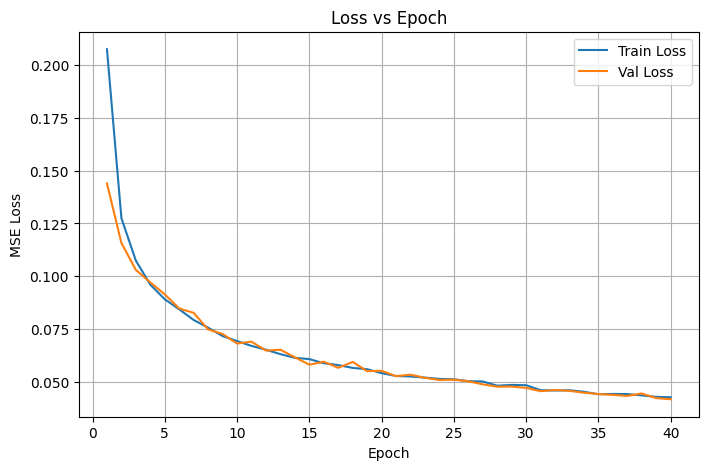

In [16]:
epochs = list(range(1, len(val_losses) + 1))

# Plot training and validation losses
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid()
plt.show()


In [20]:
model_save_path = "/kaggle/working/checkpoint.pth"

torch.save({
    'model_state_dict': nn_model.state_dict(),
    'optimizer_state_dict': optim.state_dict(),
    'epoch': epoch
}, model_save_path)

print(f"Training checkpoint saved to {model_save_path}")

Training checkpoint saved to /kaggle/working/checkpoint.pth


In [ ]:
model_save_path = "/kaggle/working/checkpoints/checkpoint.pth"

checkpoint = torch.load(model_save_path)
nn_model.load_state_dict(checkpoint['model_state_dict'])
optim.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1

nn_model.eval()  # or nn_model.train()


## Reverse process: DDPM Sampling


Now we need to define the reverse step $p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$

See that little $_\theta$? That often indicates 'learned parameters' - in this case our unet model! We use our model to predict the noise and then 'undo' the forward noise steps one at a time to go from an image that is pure noise to one that looks like a real image. \\
Below image show the sampling algorithm


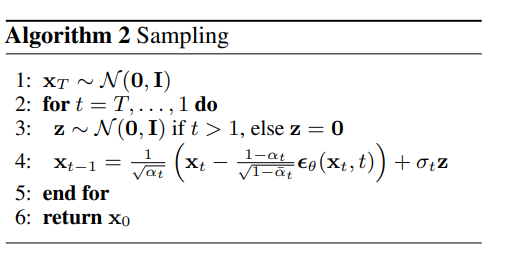


In [21]:
def p_xt_ddpm(current_noise_image, predicted_noise, time_step):
    """
    current_noise_image: x_t
    predicted_noise    : noise predicted by the model (epsilon_theta)
    time_step          : t

    Return x_(t-1)
    ----------------------------------------------------------------------------
    We'll implement the DDPM update:
      mu_theta = 1/sqrt(alpha_t) * ( x_t - ((1 - alpha_t)/sqrt(1 - alpha_bar_t)) * predicted_noise )
      sigma_t^2 = beta_t * ( (1 - alpha_bar_{t-1}) / (1 - alpha_bar_t) )
    then x_{t-1} ~ N(mu_theta, sigma_t^2 I). 
    But if t == 0, there's no noise added.

    We'll handle the random noise only for t>0.
    """
    # alphas[t], alpha_bars[t], betas[t] are global

    # gather needed terms
    alpha_t = alphas[time_step].view(-1,1,1,1)
    alpha_bar_t = alpha_bars[time_step].view(-1,1,1,1)
    beta_t = betas[time_step].view(-1,1,1,1)

    # Compute coefficients
    one_over_sqrt_alpha_t = 1.0 / torch.sqrt(alpha_t)
    term1 = one_over_sqrt_alpha_t * (current_noise_image - ( (1 - alpha_t)/(torch.sqrt(1 - alpha_bar_t)) ) * predicted_noise)

    # Compute variance term (sigma_t^2)
    # For the last step, we typically set sigma_t = 0
    # but let's keep it standard for all t>0
    sigma_t = torch.sqrt(beta_t * (1.0 - alpha_bars[time_step-1].view(-1,1,1,1)) / (1.0 - alpha_bar_t)) \
              if (time_step[0] > 0) else 0.0

    # sample from N(mu_theta, sigma_t^2 I)
    noise = torch.randn_like(current_noise_image).to(current_noise_image.device)
    x_prev = term1 + sigma_t * noise

    return x_prev

def generate_samples_ddpm(model, n=20, steps=1000):
    """
    Generate images with ddpm sampling by starting from pure noise (x_T) and iterating back to x_0.
    n: number of images to generate
    steps: total timesteps in forward process (same as 'timesteps')

    returns: a torch tensor of shape (n, C, H, W)
    """
    model.eval()
    with torch.no_grad():
        # Start from pure noise
        x_t = torch.randn(n, model.in_channels, height, height, device=device)

        # no context in this example (or set it to zeros)
        c = None
        # We'll do a descending loop
        for t_ in reversed(range(steps)):
            t_tensor = torch.tensor([t_]*n, device=device).float().unsqueeze(-1)
            # predict noise
            eps_theta = model(x_t, t_tensor, c)
            # compute x_(t-1)
            if t_ == 0:
                # Means no noise in the last step
                x_t = p_xt_ddpm(x_t, eps_theta, torch.tensor([t_]*n, device=device).long())
            else:
                x_t = p_xt_ddpm(x_t, eps_theta, torch.tensor([t_]*n, device=device).long())
        return x_t


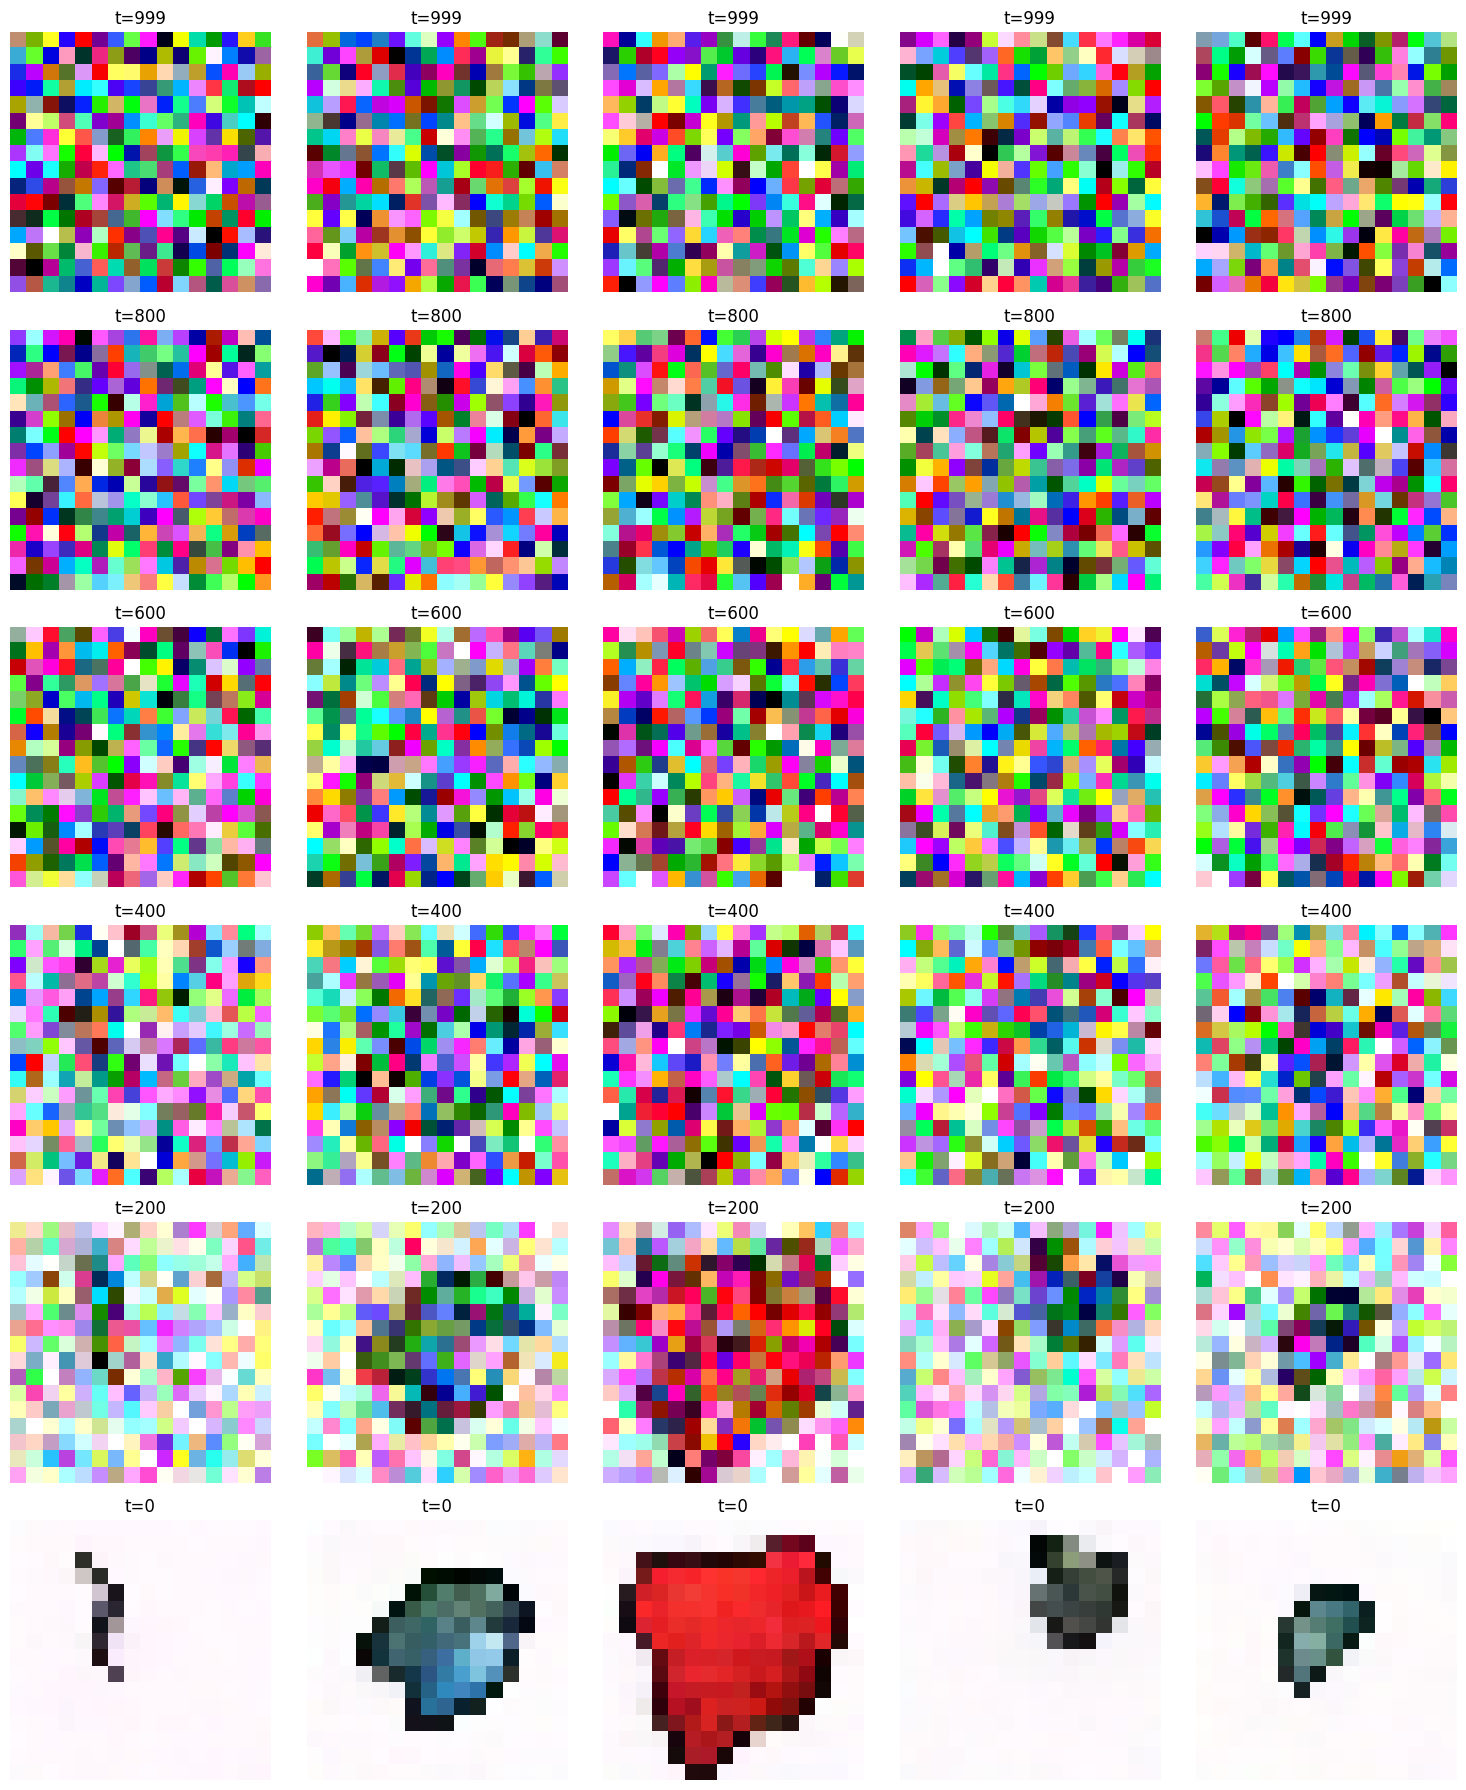

In [22]:
def generate_ddpm_samples_per_timestep(
    model, 
    total_steps=10000, 
    n=4, 
    show_steps=(999, 800, 600, 400, 200, 0)
):
    """
    Generates and plots samples of the reverse process at various timesteps.

    Args:
        model (nn.Module): Your trained UNet model.
        total_steps (int): Total number of diffusion steps (e.g. 1000).
        n (int): Number of images to generate.
        show_steps (tuple or list): Which timesteps to store & display.

    Returns:
        None (plots a figure).
    """
    model.eval()
    # Start with pure noise x_T
    x_t = torch.randn(n, model.in_channels, height, height, device=device)

    # Dictionary to save images at certain steps
    samples_dict = {}

    with torch.no_grad():
        for t_ in reversed(range(total_steps)):
            # Prepare a (batch-size) tensor of the current t
            t_tensor = torch.tensor([t_]*n, device=device).long()

            # Predict noise at current x_t
            predicted_noise = model(
                x_t, 
                t_tensor.float().unsqueeze(-1)  # shape (B,1)
            )

            # Move one step backward: x_(t-1)
            x_t = p_xt_ddpm(x_t, predicted_noise, t_tensor)

            # If t_ is in show_steps, store a copy for later plotting
            if t_ in show_steps:
                samples_dict[t_] = x_t.clone()

    # Now we make a plot of the stored images
    steps_sorted = sorted(show_steps, reverse=True)  # e.g., [999, 800, 600, 400, 200, 0]
    num_rows = len(steps_sorted)
    
    # We'll convert each stored image to [0,1] range for plotting
    fig, axes = plt.subplots(nrows=num_rows, ncols=n, figsize=(3*n, 3*num_rows))

    for row_idx, step_val in enumerate(steps_sorted):
        # If there's only 1 row or 1 column, axes might be 1D
        for col_idx in range(n):
            ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]
            # Denormalize from [-1,1] to [0,1]
            img = (samples_dict[step_val][col_idx] * 0.5 + 0.5).clamp(0,1)
            # Move channels last for matplotlib
            img_np = img.permute(1, 2, 0).detach().cpu().numpy()

            ax.imshow(img_np)
            ax.set_title(f"t={step_val}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

generate_ddpm_samples_per_timestep(
    model=nn_model,
    total_steps=timesteps,   # as from hypers: 1000
    n=5,                     # number of images
    show_steps=(999, 800, 600, 400, 200, 0)
)

## Reverse process: DDIM Sampling


Study the DDIM sampling method for reverse process and like the previous part, Implement this process regarding the DDIM method.


In [23]:
def p_xt_ddim(current_noise_image, predicted_noise, time_step, eta=0.0):
    """
    current_noise_image : x_t
    predicted_noise     : noise predicted by the model
    time_step           : t
    eta                 : controls the amount of noise (0 => deterministic sampling)

    Return x_(t-1) using the DDIM update rule.
    ---------------------------------------------------------------------------
    The DDIM update typically looks like:
      alpha_bar_t = alpha_bars[t]
      alpha_bar_t_1 = alpha_bars[t-1]
      sqrt_alpha_bar_t = sqrt(alpha_bar_t)
      sqrt_alpha_bar_t_1 = sqrt(alpha_bar_t_1)

      x0_pred = ( x_t - sqrt(1-alpha_bar_t)*predicted_noise ) / sqrt_alpha_bar_t
      x0_pred is the model's prediction of x_0

      Then
      dir_xt = sqrt(1-alpha_bar_t_1) * predicted_noise
      x_t_1 = sqrt_alpha_bar_t_1 * x0_pred + dir_xt

      We can also add some variance controlled by eta if needed.
    """

    alpha_bar_t = alpha_bars[time_step].view(-1,1,1,1)
    alpha_bar_t_1 = alpha_bars[torch.clamp(time_step-1, 0)].view(-1,1,1,1)

    sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t)
    sqrt_alpha_bar_t_1 = torch.sqrt(alpha_bar_t_1)

    # predicted x0
    x0_pred = (current_noise_image - torch.sqrt(1 - alpha_bar_t)*predicted_noise) / (sqrt_alpha_bar_t)

    # direction pointing to x_t
    dir_xt = torch.sqrt(1 - alpha_bar_t_1) * predicted_noise

    # if t=0, no further step needed, we just return x0_pred
    # but let's handle the general case
    x_t_1 = sqrt_alpha_bar_t_1 * x0_pred + dir_xt

    # If we want to incorporate some randomization, we can add some noise scaled by eta
    if eta > 0 and (time_step[0] > 0):
        sigma = eta * torch.sqrt( (1 - alpha_bar_t_1) / (1 - alpha_bar_t) ) * torch.sqrt(1 - alpha_bar_t / alpha_bar_t_1)
        noise = torch.randn_like(current_noise_image)
        x_t_1 = x_t_1 + sigma * noise

    return x_t_1


def generate_samples_ddim(model, n=20, steps=1000, eta=0.0):
    """
    Generate images using DDIM sampling, starting from pure noise x_T and iterating back to x_0.
    n: number of images
    steps: total diffusion steps
    eta: noise factor
    """
    model.eval()
    with torch.no_grad():
        x_t = torch.randn(n, model.in_channels, height, height, device=device)
        c = None

        for t_ in reversed(range(steps)):
            t_tensor = torch.tensor([t_]*n, device=device).float().unsqueeze(-1)
            eps_theta = model(x_t, t_tensor, c)
            x_t = p_xt_ddim(x_t, eps_theta, torch.tensor([t_]*n, device=device).long(), eta=eta)

        return x_t


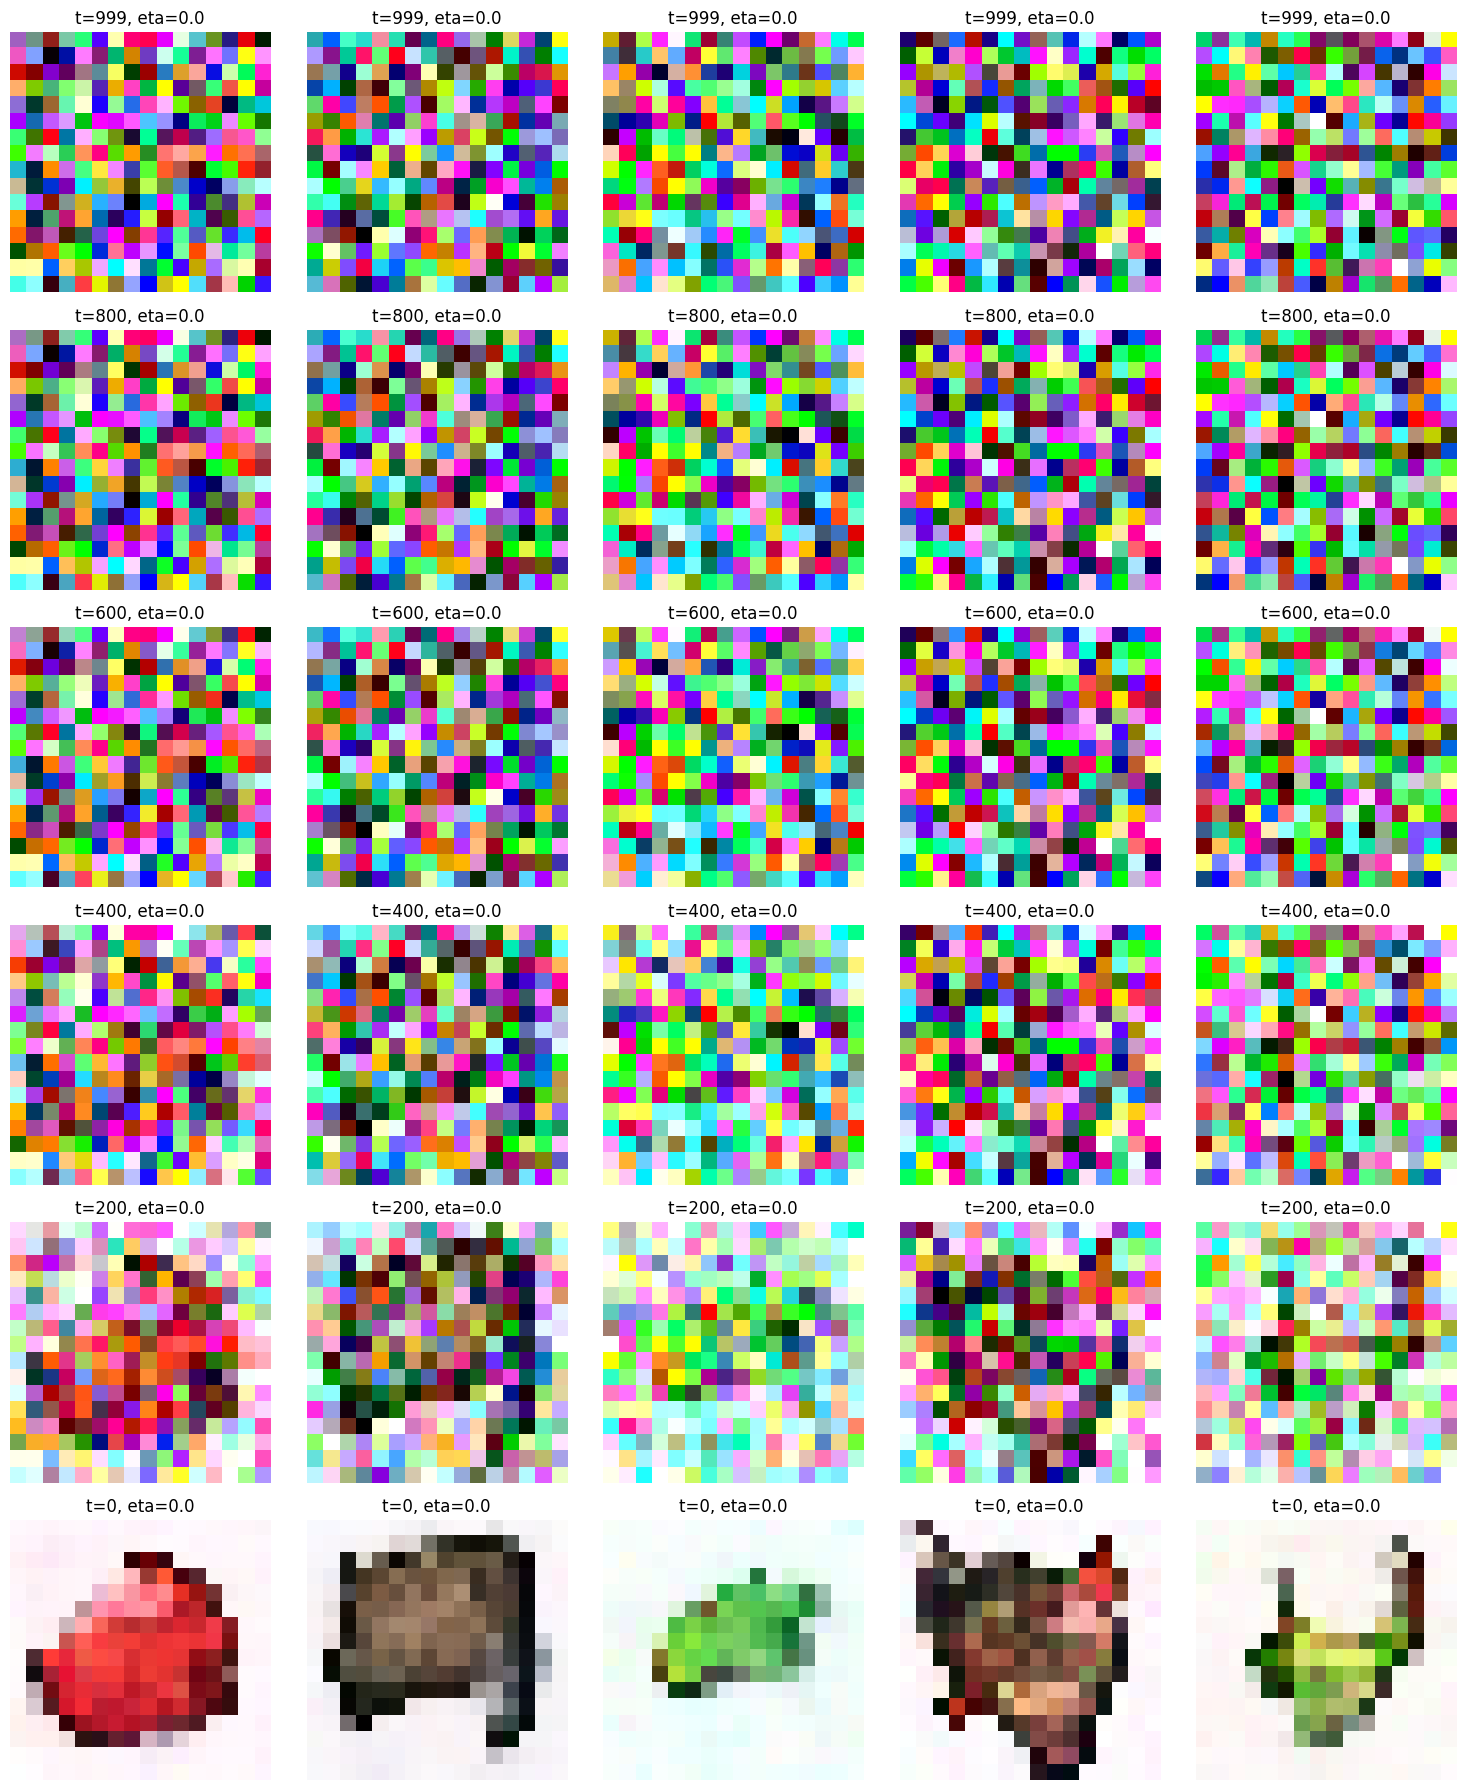

In [26]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def generate_ddim_samples_per_timestep(
    model, 
    total_steps=1000, 
    n=4, 
    show_steps=(999, 800, 600, 400, 200, 0),
    eta=0.0
):
    """
    Generates and plots samples of the reverse process at various timesteps using DDIM.

    Args:
        model (nn.Module): Your trained UNet model.
        total_steps (int): Total number of diffusion steps (e.g. 1000).
        n (int): Number of images to generate in each step.
        show_steps (tuple or list): Which timesteps to store & display (in descending order).
        eta (float): Noise factor for DDIM; 0 => deterministic sampling.

    Returns:
        None (plots a figure showing intermediate samples).
    """
    model.eval()
    # Start from pure noise x_T
    x_t = torch.randn(n, model.in_channels, height, height, device=device)

    # Dictionary to keep intermediate images
    samples_dict = {}

    with torch.no_grad():
        for t_ in reversed(range(total_steps)):
            # Prepare the t tensor
            t_tensor = torch.tensor([t_]*n, device=device).long()

            # Predict noise at current x_t
            predicted_noise = model(
                x_t, 
                t_tensor.float().unsqueeze(-1)  # shape [B, 1]
            )

            # Move one step backward: x_(t-1) using DDIM
            x_t = p_xt_ddim(x_t, predicted_noise, t_tensor, eta=eta)

            # If t_ is one of the 'show_steps', store a copy for visualization
            if t_ in show_steps:
                samples_dict[t_] = x_t.clone()

    # Plot the stored images
    steps_sorted = sorted(show_steps, reverse=True)
    num_rows = len(steps_sorted)

    fig, axes = plt.subplots(nrows=num_rows, ncols=n, figsize=(3*n, 3*num_rows))

    for row_idx, step_val in enumerate(steps_sorted):
        for col_idx in range(n):
            ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]
            # Denormalize from [-1,1] to [0,1]
            img = (samples_dict[step_val][col_idx] * 0.5 + 0.5).clamp(0,1)
            # Move channels last for plotting
            img_np = img.permute(1, 2, 0).detach().cpu().numpy()

            ax.imshow(img_np)
            ax.set_title(f"t={step_val}, eta={eta}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()


generate_ddim_samples_per_timestep(
    model=nn_model,
    total_steps=timesteps,   # as from hypers: 1000
    n=5,                     # number of images
    show_steps=(999, 800, 600, 400, 200, 0),
    eta=0.0                  # or 0.5, 1.0, etc. if we want more noise
)


## Results


Plot 20 generated images by each of generation processes implemented in the previous part


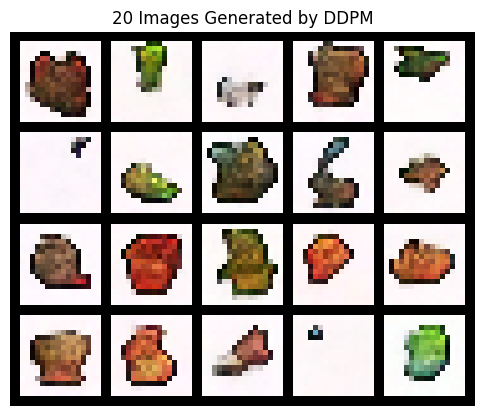

In [27]:
# Generate 20 images using DDPM sampling method
samples_ddpm = generate_samples_ddpm(nn_model, n=20, steps=timesteps)

# Denormalize from [-1,1] to [0,1] if needed
samples_ddpm_denorm = (samples_ddpm * 0.5 + 0.5).clamp(0,1)

grid_ddpm = make_grid(samples_ddpm_denorm, nrow=5)
plt.figure(figsize=(6,6))
plt.imshow(grid_ddpm.permute(1,2,0).cpu().numpy())
plt.axis('off')
plt.title("20 Images Generated by DDPM")
plt.show()


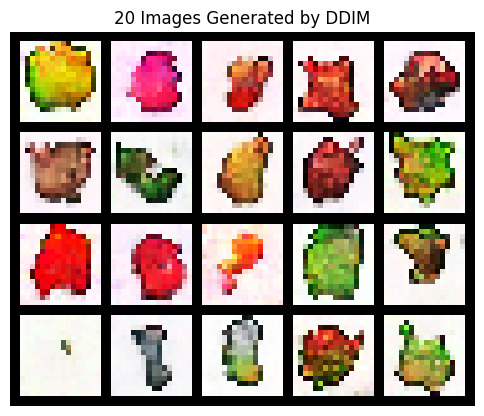

In [28]:
# Generate 20 images using DDIM sampling method
samples_ddim = generate_samples_ddim(nn_model, n=20, steps=timesteps, eta=0.0)

samples_ddim_denorm = (samples_ddim * 0.5 + 0.5).clamp(0,1)

grid_ddim = make_grid(samples_ddim_denorm, nrow=5)
plt.figure(figsize=(6,6))
plt.imshow(grid_ddim.permute(1,2,0).cpu().numpy())
plt.axis('off')
plt.title("20 Images Generated by DDIM")
plt.show()


# Evaluating the Generated Samples:


Now we want to evaluate our model. For this, we use the FID score.

First, read [this link](https://github.com/mseitzer/pytorch-fid) to become familiar with this metric and its usage in your code.


Installation

In [29]:
!pip install -qq pytorch-fid

Generate 3000 images by your model (by using either of generation processes) and save them in a directory. Also, save 3000 images from the sprites dataset and save them in another directory.


In [30]:
# TODO
# save generated images and real images

os.makedirs("generated_samples_ddpm", exist_ok=True)
os.makedirs("real_samples_sprites", exist_ok=True)

n_generate = 3000
batch_gen = 100
iters = n_generate // batch_gen

nn_model.eval()

counter_gen = 0
for i in range(iters):
    with torch.no_grad():
        x_t = torch.randn(batch_gen, nn_model.in_channels, height, height, device=device)
        for t_ in reversed(range(timesteps)):
            t_tensor = torch.tensor([t_]*batch_gen, device=device).float().unsqueeze(-1)
            eps_theta = nn_model(x_t, t_tensor)
            x_t = p_xt_ddpm(x_t, eps_theta, torch.tensor([t_]*batch_gen, device=device).long())
        gen_images = (x_t * 0.5 + 0.5).clamp(0,1)  # denormalize

    for b in range(batch_gen):
        img = gen_images[b]
        save_path = os.path.join("generated_samples_ddpm", f"gen_{counter_gen}.png")
        save_image(img, save_path)
        counter_gen += 1

# Save 3000 real sprite images
real_imgs = sprites[:n_generate]  # shape = (3000, H, W, C)
for i in range(n_generate):
    img_np = real_imgs[i]
    img_torch = torch.tensor(img_np).permute(2,0,1)  # (C,H,W)
    img_torch = (img_torch / 255.0 - 0.5) / 0.5       # match the [-1,1] scaled
    img_torch = (img_torch * 0.5 + 0.5).clamp(0,1)    # bring back [0,1] for saving
    save_path = os.path.join("real_samples_sprites", f"real_{i}.png")
    save_image(img_torch, save_path)


In [31]:
# TODO: compute the FID score using pytorch-fid package.
# You should have two image directories to compute the score: 
# 1- Directory of the original images.
# 2- Directory of the generated images (the directory that you created in the last code cell)


!python -m pytorch_fid real_samples_sprites generated_samples_ddpm --device cuda:0


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|███████████████████████████████████████| 91.2M/91.2M [00:00<00:00, 120MB/s]
100%|███████████████████████████████████████████| 60/60 [00:06<00:00,  9.38it/s]
FID:  102.44668445166292
